This is the "Pre-processing & Training Data Development" of the Capstone 2 project. In this project we would like to manipulate our data as following:

# 1. Balance the data
# 2. Evaluation a few models
## 2.1 K-neighbors with 4 most correlated features
## 2.2 K neighbors with 4 most correlated features (scaled)
## 2.3 Grid Search Cross Validation for k value
## 2.4 Decision Tree
## 2.5 Random Forest
## 2.6 K Neighbors with 4 most correlated features and 2 categorical features
## 2.7 Random Forest with 4 most correlated features and 2 categorical features
## 2.8 Random Forest with 6 principal components and 2 categorical features


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

In [53]:
# Read data to the data frame.
data_lc = pd.read_csv('lending_club_data.csv')

In [54]:
data_lc.head()

,loan_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,loan_status,purpose,dti,...,application_type,acc_open_past_24mths,mort_acc,num_tl_op_past_12m,percent_bc_gt_75,tot_hi_cred_lim,total_bc_limit,disbursement_method,debt_settlement_flag,earliest_cr_line_year
0,3600.0,36 months,13.99,C,10+ years,MORTGAGE,55000.0,1,debt_consolidation,5.91,...,Individual,4.0,1.0,3.0,0.0,178050.0,2400.0,Cash,N,2003
1,24700.0,36 months,11.99,C,10+ years,MORTGAGE,65000.0,1,small_business,16.06,...,Individual,4.0,4.0,2.0,7.7,314017.0,79300.0,Cash,N,1999
2,20000.0,60 months,10.78,B,10+ years,MORTGAGE,63000.0,1,home_improvement,10.78,...,Joint App,6.0,5.0,0.0,50.0,218418.0,6200.0,Cash,N,2000
3,10400.0,60 months,22.45,F,3 years,MORTGAGE,104433.0,1,major_purchase,25.37,...,Individual,10.0,6.0,4.0,60.0,439570.0,20300.0,Cash,N,1998
4,11950.0,36 months,13.44,C,4 years,RENT,34000.0,1,debt_consolidation,10.20,...,Individual,0.0,0.0,0.0,100.0,16900.0,9400.0,Cash,N,1987


In [55]:
data_lc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188395 entries, 0 to 1188394
Data columns (total 28 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   loan_amnt              1188395 non-null  float64
 1   term                   1188395 non-null  object 
 2   int_rate               1188395 non-null  float64
 3   grade                  1188395 non-null  object 
 4   emp_length             1188395 non-null  object 
 5   home_ownership         1188395 non-null  object 
 6   annual_inc             1188395 non-null  float64
 7   loan_status            1188395 non-null  int64  
 8   purpose                1188395 non-null  object 
 9   dti                    1188395 non-null  float64
 10  fico_range_high        1188395 non-null  float64
 11  inq_last_6mths         1188395 non-null  float64
 12  revol_util             1188395 non-null  float64
 13  initial_list_status    1188395 non-null  object 
 14  total_rec_late_fee

# 1. Balance the data

Let's count the value of column 'loan status'.

In [56]:
loan_status_count = pd.DataFrame(data_lc['loan_status'].value_counts())

In [57]:
loan_status_count

,loan_status
1,953495
0,234900


In [58]:
print(loan_status_count.loc[1, 'loan_status'] / loan_status_count.loc[0, 'loan_status'] )

4.059152830991912


We see that the amount of data points with loan_status = 1 (fully paid) is about 4 times of the amount of loan_status = 0 (defaulted), which means the data is not balanced. To ensure the high data quality we should try to keep it balanced. Since we have large amount of data, we should reduce the data point with loan_status = 1. We can keep only half of it so that the ratio is about 1.6:1. 

In [59]:
data_1 = data_lc[data_lc['loan_status']==0]

In [60]:
data_2 = data_lc[data_lc['loan_status']==1].sample(frac=0.4)

In [61]:
data_1.shape

(234900, 28)

In [62]:
data_2.shape

(381398, 28)

In [63]:
data_balanced = pd.concat([data_1, data_2], ignore_index=True)

In [64]:
data_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616298 entries, 0 to 616297
Data columns (total 28 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   loan_amnt              616298 non-null  float64
 1   term                   616298 non-null  object 
 2   int_rate               616298 non-null  float64
 3   grade                  616298 non-null  object 
 4   emp_length             616298 non-null  object 
 5   home_ownership         616298 non-null  object 
 6   annual_inc             616298 non-null  float64
 7   loan_status            616298 non-null  int64  
 8   purpose                616298 non-null  object 
 9   dti                    616298 non-null  float64
 10  fico_range_high        616298 non-null  float64
 11  inq_last_6mths         616298 non-null  float64
 12  revol_util             616298 non-null  float64
 13  initial_list_status    616298 non-null  object 
 14  total_rec_late_fee     616298 non-nu

The new data set has 616298 rows, about 52% of total amount of rows in original data.

In [65]:
data_balanced['loan_status'].value_counts()

1    381398
0    234900
Name: loan_status, dtype: int64

# 2. Evaluation a few models

We wants to evaluate a few models and select the best one based on their performance.

## 2.1 K-neighbors with 4 most correlated features

First let's figure out which features are most correlated to our target feature, loan status.

In [66]:
columns_numerical = data_balanced.select_dtypes(['float','int64']).columns

In [67]:
columns_numerical

Index(['loan_amnt', 'int_rate', 'annual_inc', 'loan_status', 'dti',
       'fico_range_high', 'inq_last_6mths', 'revol_util', 'total_rec_late_fee',
       'recoveries', 'last_pymnt_amnt', 'last_fico_range_low',
       'acc_open_past_24mths', 'mort_acc', 'num_tl_op_past_12m',
       'percent_bc_gt_75', 'tot_hi_cred_lim', 'total_bc_limit',
       'earliest_cr_line_year'],
      dtype='object')

In [68]:
col_corr = []
data_corr = []
for item in columns_numerical:
    data_corr.append(abs(data_balanced['loan_status'].corr(data_balanced[item])))
    col_corr.append(item)
    
df_corr = pd.DataFrame({'column':col_corr, 'correlation':data_corr})
df_corr.sort_values('correlation')

,column,correlation
2,annual_inc,0.046232
18,earliest_cr_line_year,0.061097
7,revol_util,0.071557
15,percent_bc_gt_75,0.080643
6,inq_last_6mths,0.080933
0,loan_amnt,0.084976
17,total_bc_limit,0.087982
13,mort_acc,0.094020
16,tot_hi_cred_lim,0.096197
14,num_tl_op_past_12m,0.104735


We can see that columns 'last_fico_range_low', 'recoveries', 'last_pymnt_amnt', and 'int_rate' have the highest correlation with loan status. So we would like to use them as predictor features and evaluate the K neighbors model.

In [69]:
cols_kn = ['last_fico_range_low', 'recoveries', 'last_pymnt_amnt', 'int_rate']

In [70]:
X = data_balanced[cols_kn]

In [71]:
X.head()

,last_fico_range_low,recoveries,last_pymnt_amnt,int_rate
0,580.0,1618.90,471.70,19.48
1,0.0,368.37,146.16,14.85
2,625.0,0.00,565.09,12.88
3,0.0,0.00,701.01,24.24
4,600.0,0.00,581.58,13.99


In [72]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616298 entries, 0 to 616297
Data columns (total 4 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   last_fico_range_low  616298 non-null  float64
 1   recoveries           616298 non-null  float64
 2   last_pymnt_amnt      616298 non-null  float64
 3   int_rate             616298 non-null  float64
dtypes: float64(4)
memory usage: 18.8 MB


In [73]:
y = data_balanced['loan_status']

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 21)

In [75]:
knn_1 = KNeighborsClassifier(n_neighbors=5)

In [76]:
knn_1.fit(X_train, y_train)

KNeighborsClassifier()

In [77]:
y_pred = knn_1.predict(X_test)

In [78]:
score_1 = knn_1.score(X_test, y_test)

In [79]:
print(score_1)

0.9556125263670291


In [80]:
print(confusion_matrix(y_test, y_pred))

[[54994  3571]
 [ 3268 92242]]


In [127]:
classification_report_1 = classification_report(y_test, y_pred, digits = 3, output_dict=True)

In [129]:
print(classification_report(y_test, y_pred, digits = 3))

              precision    recall  f1-score   support

           0      0.944     0.939     0.941     58565
           1      0.963     0.966     0.964     95510

    accuracy                          0.956    154075
   macro avg      0.953     0.952     0.953    154075
weighted avg      0.956     0.956     0.956    154075



In [82]:
X.head()

,last_fico_range_low,recoveries,last_pymnt_amnt,int_rate
0,580.0,1618.90,471.70,19.48
1,0.0,368.37,146.16,14.85
2,625.0,0.00,565.09,12.88
3,0.0,0.00,701.01,24.24
4,600.0,0.00,581.58,13.99


#### Conclusion: From the study above, we can see that the score for the case with 4 most correlated features is 0.956, and the classification report is shown above. This gives us a bottom line and we will use it as reference to evaluate other models. 

## 2.2 K neighbors with 4 most correlated features (scaled)

In this model, we will still use K neighbors and the 4 features same as model 2.1. But in this model we will scale the 4 features. The reason is to see if the model performance will improve after the scaling.

In [83]:
from sklearn.preprocessing import scale

In [84]:
X_scaled = scale(X)

In [85]:
X_scaled.shape

(616298, 4)

In [86]:
X.mean(), X.std()

(last_fico_range_low     624.098764
 recoveries              481.855320
 last_pymnt_amnt        4487.367800
 int_rate                 13.838854
 dtype: float64,
 last_fico_range_low     162.036929
 recoveries             1311.297357
 last_pymnt_amnt        6752.739044
 int_rate                  4.946033
 dtype: float64)

In [97]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X_scaled, y, random_state = 21)

In [98]:
knn_2 = KNeighborsClassifier(n_neighbors=5)

In [99]:
knn_2.fit(X1_train, y1_train)

KNeighborsClassifier()

In [101]:
y1_pred = knn_2.predict(X1_test)

In [102]:
score_2 = knn_2.score(X1_test, y1_test)

In [122]:
print(classification_report(y1_test, y1_pred, digits=3))

              precision    recall  f1-score   support

           0      0.941     0.940     0.940     58565
           1      0.963     0.964     0.963     95510

    accuracy                          0.955    154075
   macro avg      0.952     0.952     0.952    154075
weighted avg      0.955     0.955     0.955    154075



In [123]:
classification_report_2 = classification_report(y1_test, y1_pred, digits=3, output_dict=True)

In [107]:
print('Score before scaling:', round(score_1, 3), '  Score after scaling:', round(score_2,3))

Score before scaling: 0.956   Score after scaling: 0.955


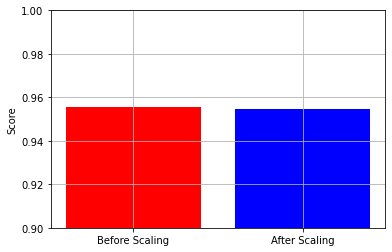

In [151]:
plt.bar(['Before Scaling','After Scaling'], [score_1, score_2], color=['r', 'b'])
plt.ylim(0.9, 1.0)
plt.grid(True)
plt.ylabel('Score')
plt.show()

In [130]:
report_1 = pd.DataFrame(classification_report_1)

In [131]:
report_2 = pd.DataFrame(classification_report_2)

In [133]:
f1_score_value = [report_1.loc['f1-score','0'], report_1.loc['f1-score','1'], report_2.loc['f1-score','0'], report_2.loc['f1-score','1']]

In [139]:
f1_score_df =pd.DataFrame({'loan_status':[0,1,0,1], 'Scaled/Origin':['Origin', 'Origin', 'Scaled', 'Scaled'], 'f1_score':f1_score_value})

In [140]:
f1_score_df

,loan_status,Scaled/Origin,f1_score
0,0,Origin,0.941460
1,1,Origin,0.964254
2,0,Scaled,0.940372
3,1,Scaled,0.963465


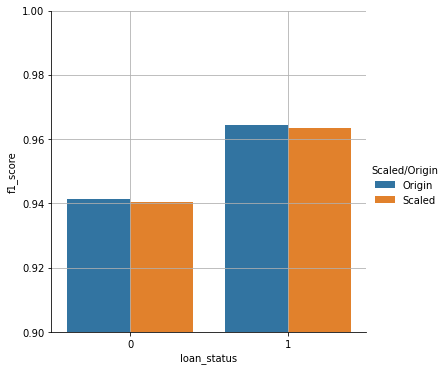

In [152]:
sns.catplot(x='loan_status', y='f1_score', data=f1_score_df, hue='Scaled/Origin', kind='bar')
plt.ylim(0.9, 1.0)
plt.grid(True)
plt.show()

#### Conclusion: From the two plots above, we can see that after the scaling, there is almost no improvment in both scole (accuracy) and the f1 score. Therefore we get the conclusion that the scaling is not needed for this case. So we will not do scaling for the K neighbors models. 

## 2.3 Grid Search Cross Validation for k value

In our previous analysis we use k value(n_neighbors) to be 5. This is just our intuitive guess. We wants to use cross validation to find the best value. We just want to test a few values as (3, 5, 7, 9) 

In [144]:
from sklearn.model_selection import GridSearchCV

In [145]:
param_grid = {'n_neighbors': np.arange(3,10,2)}

In [146]:
knn_model = KNeighborsClassifier()

In [147]:
knn_cv = GridSearchCV(knn_model, param_grid, cv=5)

In [148]:
knn_cv.fit(X, y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([3, 5, 7, 9])})

In [149]:
knn_cv.best_params_

{'n_neighbors': 9}

In [150]:
knn_cv.best_score_

0.9574410318310476

#### Conclusion: Result shows that the best n_neighbors value is 9.

## 2.4 Decision Tree

Let's try the model of decision tree by using entropy as criterion.

In [154]:
from sklearn import tree, metrics

In [155]:
entr_model = tree.DecisionTreeClassifier(criterion='entropy', random_state=1234)

# Call fit() on entr_model
entr_model.fit(X_train, y_train)

# Call predict() on entr_model with X_test passed to it, and assign the result to a variable y_pred 
y_pred_dt = entr_model.predict(X_test)


In [156]:
score_3 = entr_model.score(X_test, y_test)

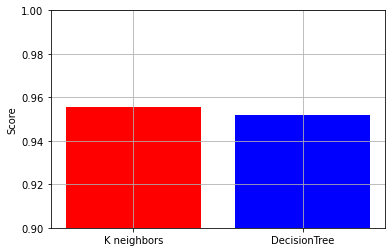

In [158]:
plt.bar(['K neighbors','DecisionTree'], [score_1, score_3], color=['r', 'b'])
plt.ylim(0.9, 1.0)
plt.grid(True)
plt.ylabel('Score')
plt.show()

In [159]:
classification_report_3 = classification_report(y_test, y_pred_dt, digits=3, output_dict=True)

In [160]:
report_3 = pd.DataFrame(classification_report_3)

In [161]:
f1_score_value = [report_1.loc['f1-score','0'], report_1.loc['f1-score','1'], report_3.loc['f1-score','0'], report_3.loc['f1-score','1']]

In [162]:
f1_score_df =pd.DataFrame({'loan_status':[0,1,0,1], 'Model':['K-neighbors', 'K-neighbors', 'DecisionTree', 'DecisionTree'], 'f1_score':f1_score_value})

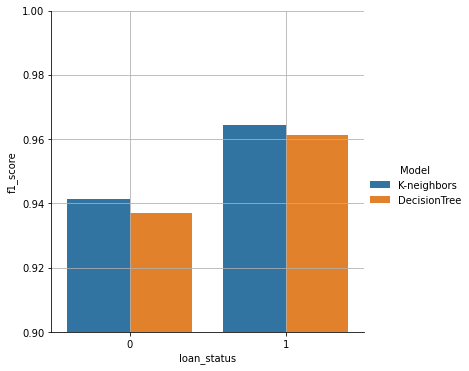

In [163]:
sns.catplot(x='loan_status', y='f1_score', data=f1_score_df, hue='Model', kind='bar')
plt.ylim(0.9, 1.0)
plt.grid(True)
plt.show()

#### Conclusion: Results show that the decision tree model performs not as good as the k neighbors.

## 2.5 Random Forest

Now Let's try random forest.

In [164]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [165]:
RFModel = RandomForestClassifier(random_state = 123)

# Model and fit
RFModel.fit(X_train, y_train)
y_pred_rf = RFModel.predict(X_test)

In [166]:
score_4 = RFModel.score(X_test, y_test)

In [167]:
print(classification_report(y_test, y_pred_rf, digits=3))

              precision    recall  f1-score   support

           0      0.947     0.949     0.948     58565
           1      0.969     0.968     0.968     95510

    accuracy                          0.961    154075
   macro avg      0.958     0.958     0.958    154075
weighted avg      0.961     0.961     0.961    154075



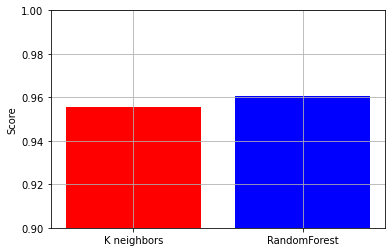

In [168]:
plt.bar(['K neighbors','RandomForest'], [score_1, score_4], color=['r', 'b'])
plt.ylim(0.9, 1.0)
plt.grid(True)
plt.ylabel('Score')
plt.show()

In [169]:
classification_report_4 = classification_report(y_test, y_pred_rf, digits=3, output_dict=True)

In [170]:
report_4 = pd.DataFrame(classification_report_4)

In [171]:
f1_score_value = [report_1.loc['f1-score','0'], report_1.loc['f1-score','1'], report_4.loc['f1-score','0'], report_4.loc['f1-score','1']]

In [172]:
f1_score_df =pd.DataFrame({'loan_status':[0,1,0,1], 'Model':['K-neighbors', 'K-neighbors', 'RandomForest', 'RandomForest'], 'f1_score':f1_score_value})

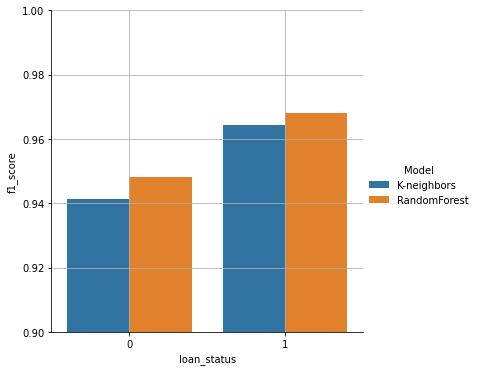

In [173]:
sns.catplot(x='loan_status', y='f1_score', data=f1_score_df, hue='Model', kind='bar')
plt.ylim(0.9, 1.0)
plt.grid(True)
plt.show()

#### Conclusion: Results show that the random forest model DOES improve the performance. So far it is the best model among all.

## 2.6 Logistic Regression

In [174]:
from sklearn.linear_model import LogisticRegression

In [175]:
logreg = LogisticRegression()

In [176]:
logreg.fit(X_train, y_train)

LogisticRegression()

In [177]:
y_pred_lr = logreg.predict(X_test)

In [178]:
score_5 = logreg.score(X_test, y_test)

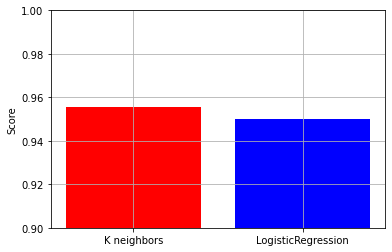

In [180]:
plt.bar(['K neighbors','LogisticRegression'], [score_1, score_5], color=['r', 'b'])
plt.ylim(0.9, 1.0)
plt.grid(True)
plt.ylabel('Score')
plt.show()

In [181]:
classification_report_5 = classification_report(y_test, y_pred_lr, digits=3, output_dict=True)

In [182]:
report_5 = pd.DataFrame(classification_report_5)

In [183]:
f1_score_value = [report_1.loc['f1-score','0'], report_1.loc['f1-score','1'], report_5.loc['f1-score','0'], report_5.loc['f1-score','1']]

In [184]:
f1_score_df =pd.DataFrame({'loan_status':[0,1,0,1], 'Model':['K-neighbors', 'K-neighbors', 'LogisticRegression', 'LogisticRegression'], 'f1_score':f1_score_value})

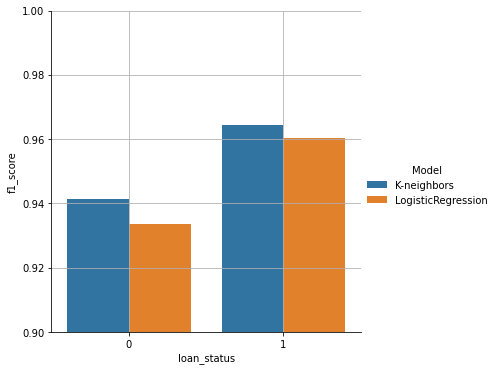

In [185]:
sns.catplot(x='loan_status', y='f1_score', data=f1_score_df, hue='Model', kind='bar')
plt.ylim(0.9, 1.0)
plt.grid(True)
plt.show()

#### Conclusion: The logistic regression is fast but the result is not as good as the K neighbors model.

## 2.6 K Neighbors with 4 most correlated features and 2 categorical features

We want to see the influence of those categorical featuers. So we would like to include the two categorical features in our model. 

In [186]:
cols_for_model = ['last_fico_range_low', 'recoveries', 'last_pymnt_amnt', 'int_rate','term', 'debt_settlement_flag']

In [187]:
X_new = data_balanced[cols_for_model]

In [188]:
X_new.head()

,last_fico_range_low,recoveries,last_pymnt_amnt,int_rate,term,debt_settlement_flag
0,580.0,1618.90,471.70,19.48,60 months,N
1,0.0,368.37,146.16,14.85,36 months,N
2,625.0,0.00,565.09,12.88,36 months,N
3,0.0,0.00,701.01,24.24,60 months,N
4,600.0,0.00,581.58,13.99,60 months,N


In [189]:
X_new = pd.get_dummies(X_new, drop_first=True)

In [190]:
X_new.head()

,last_fico_range_low,recoveries,last_pymnt_amnt,int_rate,term_ 60 months,debt_settlement_flag_Y
0,580.0,1618.90,471.70,19.48,1,0
1,0.0,368.37,146.16,14.85,0,0
2,625.0,0.00,565.09,12.88,0,0
3,0.0,0.00,701.01,24.24,1,0
4,600.0,0.00,581.58,13.99,1,0


In [191]:
Xn_train, Xn_test, yn_train, yn_test = train_test_split(X_new, y, random_state = 21)

In [192]:
knn_n = KNeighborsClassifier(n_neighbors=9)

In [193]:
knn_n.fit(Xn_train, yn_train)

KNeighborsClassifier(n_neighbors=9)

In [194]:
yn_pred = knn_n.predict(Xn_test)

In [195]:
score_6 = knn_n.score(Xn_test, yn_test)

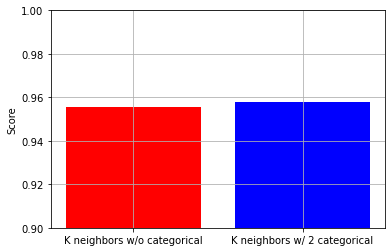

In [196]:
plt.bar(['K neighbors w/o categorical','K neighbors w/ 2 categorical'], [score_1, score_6], color=['r', 'b'])
plt.ylim(0.9, 1.0)
plt.grid(True)
plt.ylabel('Score')
plt.show()

In [197]:
classification_report_6 = classification_report(y_test, yn_pred, digits=3, output_dict=True)

In [198]:
report_6 = pd.DataFrame(classification_report_6)

In [199]:
f1_score_value = [report_1.loc['f1-score','0'], report_1.loc['f1-score','1'], report_6.loc['f1-score','0'], report_6.loc['f1-score','1']]

In [200]:
f1_score_df =pd.DataFrame({'loan_status':[0,1,0,1], 'Model':['K neighbors w/o categorical', 'K neighbors w/o categorical', 'K neighbors w/ 2 categorical', 'K neighbors w/ 2 categorical'], 'f1_score':f1_score_value})

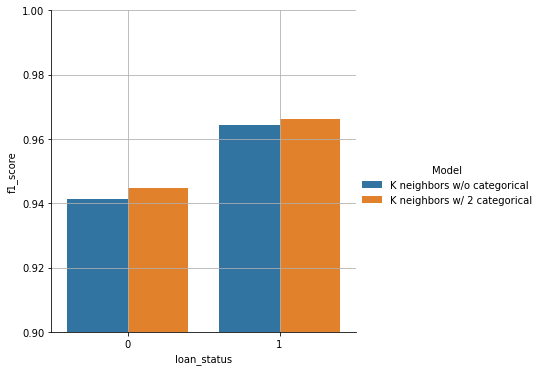

In [201]:
sns.catplot(x='loan_status', y='f1_score', data=f1_score_df, hue='Model', kind='bar')
plt.ylim(0.9, 1.0)
plt.grid(True)
plt.show()

#### Conclusion: We do see that after the two categorical features included, the model performance was improved.

## 2.7 Random Forest with 4 most correlated features and 2 categorical features

In [202]:
NewRFModel = RandomForestClassifier(random_state = 123)

# Model and fit
NewRFModel.fit(Xn_train, yn_train)
yn_pred_rf = NewRFModel.predict(Xn_test)

In [203]:
score_7 = NewRFModel.score(Xn_test, yn_test)

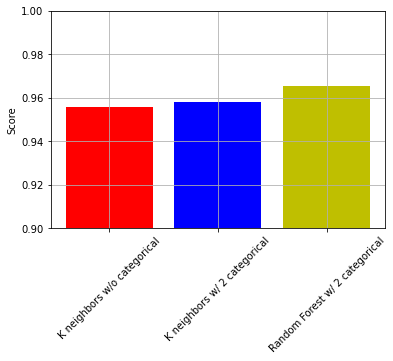

In [209]:
plt.bar(['K neighbors w/o categorical','K neighbors w/ 2 categorical', 'Random Forest w/ 2 categorical'], [score_1, score_6,score_7], color=['r', 'b', 'y'])
plt.ylim(0.9, 1.0)
plt.xticks(rotation=45)
plt.grid(True)
plt.ylabel('Score')
plt.show()

In [212]:
print(classification_report(yn_test, yn_pred_rf, digits=3))

              precision    recall  f1-score   support

           0      0.955     0.954     0.955     58565
           1      0.972     0.972     0.972     95510

    accuracy                          0.965    154075
   macro avg      0.963     0.963     0.963    154075
weighted avg      0.965     0.965     0.965    154075



In [213]:
classification_report_7 = classification_report(y_test, yn_pred_rf, digits=3, output_dict=True)

In [215]:
report_7 = pd.DataFrame(classification_report_7)

In [216]:
f1_score_value = [report_1.loc['f1-score','0'], report_1.loc['f1-score','1'], report_6.loc['f1-score','0'], 
                  report_6.loc['f1-score','1'], report_7.loc['f1-score','0'], report_7.loc['f1-score','1']]

In [217]:
f1_score_df =pd.DataFrame({'loan_status':[0,1,0,1,0,1], 'Model':['K_neib w/o cat', 'K_neib w/o cat', 'K_neib w/ 2 cat', 
        'K_neib w/ 2 cat','RandmFrst w/ 2 categorical','RandmFrst w/ 2 categorical'], 'f1_score':f1_score_value})

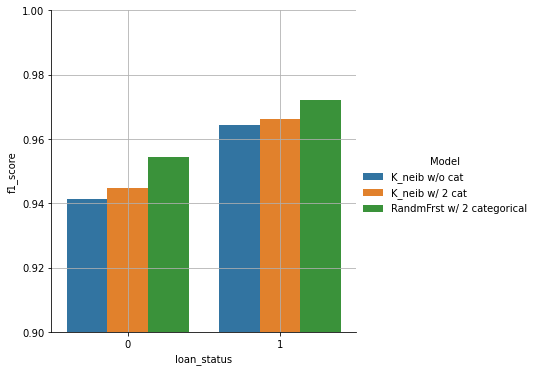

In [218]:
sns.catplot(x='loan_status', y='f1_score', data=f1_score_df, hue='Model', kind='bar')
plt.ylim(0.9, 1.0)
plt.grid(True)
plt.show()

#### Conclusion: Based on the comparason of all three models, we can see that the random forest model with 4 numerical features and two categorical features are much better than the other two.

## 2.8 Random Forest with 6 principal components and 2 categorical features

In [234]:
from sklearn.decomposition import PCA

In [265]:
pca = PCA(n_components=6)
data_pca = pca.fit(scale(data_balanced[columns_numerical]))

In [266]:
transformed = data_pca.transform(scale(data_balanced[columns_numerical]))

In [240]:
transformed.shape

(616298, 6)

In [242]:
pc = ['pc_1','pc_2','pc_3','pc_4','pc_5','pc_6']

In [267]:
X3 = pd.DataFrame(transformed, columns=pc)

In [268]:
X3['term'] = data_balanced['term']
X3['debt_settlement_flag'] = data_balanced['debt_settlement_flag']

In [269]:
X3.head()

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,term,debt_settlement_flag
0,-1.254973,1.400676,-0.855301,0.563960,0.550505,1.630102,60 months,N
1,-2.160384,-1.501013,-1.830644,3.051431,0.656750,0.523231,36 months,N
2,-1.334640,0.785947,0.692707,3.176929,1.073338,1.676662,36 months,N
3,-2.532581,3.082344,0.339714,0.095930,0.485966,0.107209,60 months,N
4,2.000075,3.935626,-1.664366,0.453575,-0.833690,-2.051915,60 months,N


In [270]:
X3 = pd.get_dummies(X3, drop_first=True)

In [272]:
X_train, X_test, y_train, y_test = train_test_split(X3, y, random_state = 21)

In [273]:
NewRFModel3 = RandomForestClassifier(random_state = 123)

# Model and fit
NewRFModel3.fit(X_train, y_train)
y_pred_rf = NewRFModel3.predict(X_test)

In [280]:
score_8 = NewRFModel3.score(X_test, y_test)

In [281]:
score_7, score_8

(0.9654389096219373, 0.9955995456758072)

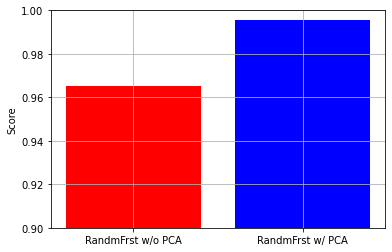

In [291]:
plt.bar(['RandmFrst w/o PCA','RandmFrst w/ PCA'], [score_7, score_8], color=['r', 'b'])
plt.ylim(0.9, 1.0)
plt.grid(True)
plt.ylabel('Score')
plt.show()

In [282]:
classification_report_8 = classification_report(y_test, y_pred_rf, digits=3, output_dict=True)

In [283]:
print(classification_report(y_test, y_pred_rf, digits=3))

              precision    recall  f1-score   support

           0      0.990     0.999     0.994     58565
           1      0.999     0.994     0.996     95510

    accuracy                          0.996    154075
   macro avg      0.994     0.996     0.995    154075
weighted avg      0.996     0.996     0.996    154075



In [284]:
report_8 = pd.DataFrame(classification_report_8)

In [285]:
f1_score_value = [report_7.loc['f1-score','0'], report_7.loc['f1-score','1'], report_8.loc['f1-score','0'], 
                  report_8.loc['f1-score','1']]

In [286]:
f1_score_df =pd.DataFrame({'loan_status':[0,1,0,1], 'Model':['RandmFrst w/o PCA', 'RandmFrst w/o PCA', 
                                                             'RandmFrst w/ PCA', 'RandmFrst w/ PCA'], 'f1_score':f1_score_value})

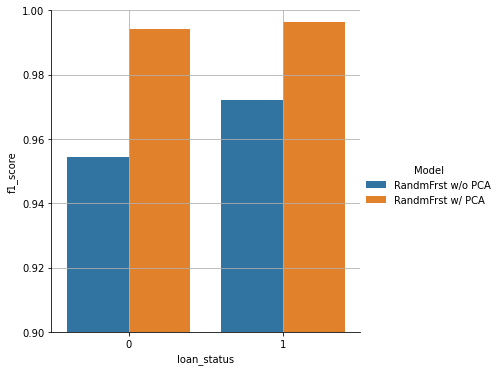

In [287]:
sns.catplot(x='loan_status', y='f1_score', data=f1_score_df, hue='Model', kind='bar')
plt.ylim(0.9, 1.0)
plt.grid(True)
plt.show()

In [288]:
# write balanced data to file.
file_name = 'lending_club_data_balanced.csv'
data_balanced.to_csv(file_name, index=False)

### Conclusion: The model with PCA gives us amazing result: both the accuracy and f1 score reaches 99.5%! That's a very high result and it is surely the highest we can reach. So we will take this happily. 

## Final Conclusion: In this study, first we balanced the data by dropping 60% of data points of fully paid loans. Then we run a few train/test models and evaluate their performance. The final model we select is the random forest with 6 principal components after the PCA, and two categorical features are also included as predictor. This model shows that we can predict about 99.5% of all loans correctly. That's surely a very high score. 